In [ ]:
from poker_utils.constants import DECK_DICT
from poker_utils.hands import normalize_hand
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from itertools import combinations
import torch.nn.functional as F
from poker_utils.model import plot_train_loss
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from poker_utils.model import (analyze_embeddings, 
                               save_model_and_embeddings, evaluate_hand_hand_equity, 
                               prob_embeddings, plot_train_loss)

In [232]:
base_data = pd.read_csv("data/raw/base_hand_data.csv").set_index("hand")
blocker_data = pd.read_csv("data/raw/preflop_block_data.csv").set_index('hand')
ev_data = pd.read_csv('data/raw/ev_pca_data.csv').set_index('hand').filter(regex="play")
equity_data = pd.read_csv("data/processed/equity_totals.csv").set_index("hand")
equity_matrix = pd.read_csv("data/processed/equity_matrix.csv").set_index("hand")

In [233]:
hand_characteristics = [
    'suited', 'connectedness', 'pair', 'high_card', 'low_card',
    'rank_diff', 'broadway', 'low_pair', 'medium_pair',
    'high_pair', 'suited_broadway', 'connector', 'one_gap', 'two_gap',
    'suited_connector', 'suited_one_gap', 'suited_two_gap',
]

In [234]:
def normalize_hand_idx(indexes: tuple):
    return normalize_hand((DECK_DICT[indexes[0]], DECK_DICT[indexes[1]]))

In [235]:
from sklearn.model_selection import train_test_split

In [236]:
hands = list(combinations(range(52), 2))

In [237]:
X_train, X_test = train_test_split(hands, test_size=0.2, random_state=29)

In [284]:
from poker_utils.constants import RANKS_DICT

In [285]:
RANKS_DICT

{0: '2',
 1: '3',
 2: '4',
 3: '5',
 4: '6',
 5: '7',
 6: '8',
 7: '9',
 8: 'T',
 9: 'J',
 10: 'Q',
 11: 'K',
 12: 'A'}

In [239]:
class TransformerDataset(Dataset):
    def __init__(self, train=None):
        all_hands = list(combinations(range(52), 2))
        if train is not None:
            h_train, h_test = train_test_split(all_hands, test_size=0.2, random_state=29)
            if train:
                self.all_hands = h_train
            else:
                self.all_hands = h_test
        else:
            self.all_hands = all_hands
            
        self.base_data = base_data[hand_characteristics].copy()
        self.ev_profiles = ev_data.copy()
    def __len__(self):
        return len(self.all_hands)
    
    def __getitem__(self, idx):
        hand = self.all_hands[idx]
        hand_norm = normalize_hand_idx(hand)
        ev_profile = self.ev_profiles.loc[hand_norm].to_numpy()
        base_info = self.base_data.loc[hand_norm].to_numpy()
        return (
            torch.tensor(hand),
            torch.tensor(base_info, dtype=torch.float32),
            torch.tensor(ev_profile, dtype=torch.float32)
        )
        

In [240]:
train_data = TransformerDataset(train=True)
val_data = TransformerDataset(train=False)
full_data = TransformerDataset()
trainloader = DataLoader(train_data, batch_size=64, shuffle=True)
valloader = DataLoader(val_data, batch_size=64, shuffle=False)
fullloader = DataLoader(full_data, batch_size=64, shuffle=False)

In [241]:
class HandTransFormer(nn.Module):
    def __init__(self, embedding_dim=8, hand_features=17, ev_features=54):
        super().__init__()
        
        self.card_embedder = nn.Embedding(52, embedding_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=2, batch_first=True)
        self.hand_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.cls_token = nn.Parameter(torch.zeros(1,1,embedding_dim))
        nn.init.xavier_uniform_(self.cls_token)
    
        self.ev_head = nn.Linear(embedding_dim, ev_features)
        self.hand_char_head = nn.Linear(embedding_dim, hand_features)
        
        self.hand_projector = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.ev_projector = nn.Sequential(
            nn.Linear(ev_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.hand_char_projector = nn.Sequential(
            nn.Linear(hand_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
    def forward(self, token_ids, hand_char, ev_profiles):
        batch_size = token_ids.shape[0]
        card_embeddings = self.card_embedder(token_ids)
        cls = self.cls_token.expand(batch_size, 1, -1)
        x = torch.cat([cls, card_embeddings], dim=1)
        x_encoded = self.hand_encoder(x)
        hand_embedding = x_encoded[:, 0, :] # [cls, card1, card2]
        
        ev_pred = self.ev_head(hand_embedding)
        loss_ev = F.mse_loss(ev_pred, ev_profiles)
        
        hand_proj = F.normalize(self.hand_projector(hand_embedding), dim=1)
        ev_proj = F.normalize(self.ev_projector(ev_profiles))
        hand_char_proj = F.normalize(self.hand_char_projector(hand_char))
        
        logits = hand_proj @ ev_proj.T
        labels = torch.arange(batch_size)
        emb_ev_loss = (F.cross_entropy(logits, labels) + F.cross_entropy(logits.T, labels)) / 2
        
        logits = hand_proj @ hand_char_proj.T
       
        emb_hand_char_loss = (F.cross_entropy(logits, labels) + F.cross_entropy(logits.T, labels)) / 2
        return {
            "hand_embedding": hand_embedding,
            "ev_prediction": ev_pred,
            "loss_ev": loss_ev,
            "emb_ev_loss": emb_ev_loss,
            "emb_hand_char_loss": emb_hand_char_loss
        }
        

In [252]:
model = HandTransFormer(16)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
def loss_func(loss_ev, emb_ev_loss, emb_hand_char_loss, ratios=[1.,1.,1.]):
    return loss_ev*ratios[0] + emb_ev_loss*ratios[1] + emb_hand_char_loss*ratios[2]

In [ ]:
epochs = 500
train_losses = []
val_losses =[]
for epoch in range(epochs):
    tot_train_loss = 0
    model.train()
    for hand_ids, char_data, ev_data in trainloader:
        optimizer.zero_grad()
        output = model(hand_ids, char_data, ev_data)
        tot_loss = loss_func(
            output['loss_ev'], 
            output['emb_ev_loss'], 
            output['emb_hand_char_loss']
            )
        tot_loss.backward()
        optimizer.step()
        tot_train_loss += tot_loss.item()
    avg_train_loss = tot_train_loss / len(trainloader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    with torch.no_grad():
        tot_val_loss = 0
        for hand_ids, char_data, ev_data in valloader:
            output = model(hand_ids, char_data, ev_data)
            tot_loss = loss_func(
                output['loss_ev'], 
                output['emb_ev_loss'], 
                output['emb_hand_char_loss']
                )
            
            tot_val_loss += tot_loss.item()
        avg_val_loss = tot_val_loss / len(valloader)
        val_losses.append(avg_val_loss)
        
        
        

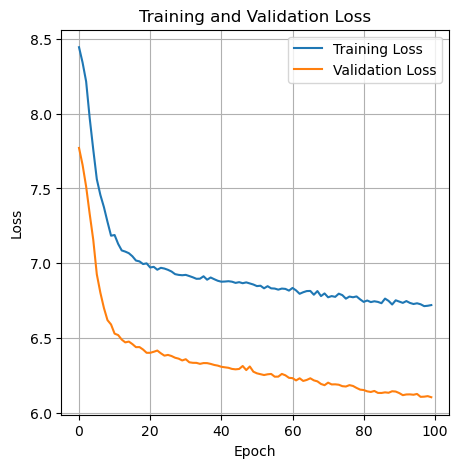

In [255]:
plot_train_loss(train_losses, val_losses)

In [264]:
model.eval()
with torch.no_grad():
    card_embeddings = model.card_embedder.weight.data.numpy()

In [ ]:
card_similarity_df = pd.DataFrame(cosine_similarity(card_embeddings), 
                                  index=DECK_DICT.values(),
                                  columns=DECK_DICT.values())

In [328]:
ids = []
embeddings = []
model.eval()
with torch.no_grad():
    for hand_ids, char_data, ev_data in fullloader:
        output = model(hand_ids, char_data, ev_data)
        emb = F.normalize(output['hand_embedding'], p=2, dim=1)
        embeddings.append(emb.numpy())
        ids.append(hand_ids.numpy())
hand_ids = np.concat(ids)
embeddings = np.concat(embeddings)

In [329]:
embedding_data = pd.DataFrame(np.concat([hand_ids, embeddings], axis=1))

In [ ]:
embedding_data[0] = embedding_data[0].astype(int).apply(lambda x: DECK_DICT[x])
embedding_data[1] = embedding_data[1].astype(int).apply(lambda x: DECK_DICT[x])
embedding_data.rename({0:"card1",1:'card2'},axis=1, inplace=True)
embedding_data['hand'] = embedding_data.apply(lambda x: normalize_hand((x['card1'],x['card2'])), axis=1)
embedding_data['hand'] = pd.Categorical(embedding_data['hand'])

In [357]:
embeddings_agg = embedding_data.iloc[:,2:].groupby("hand", observed=False).mean().to_numpy()

In [334]:
tsne = TSNE(n_components=2, perplexity=30, random_state=29)
embeddings_2d = tsne.fit_transform(embeddings)

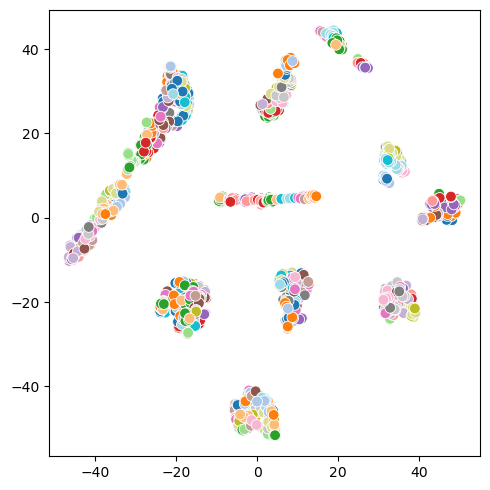

In [342]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=embeddings_2d[:,0], 
                y=embeddings_2d[:,1], 
                hue=embedding_data['hand'], 
                palette="tab20", s=60)

plt.legend().remove()
plt.tight_layout()
plt.show()


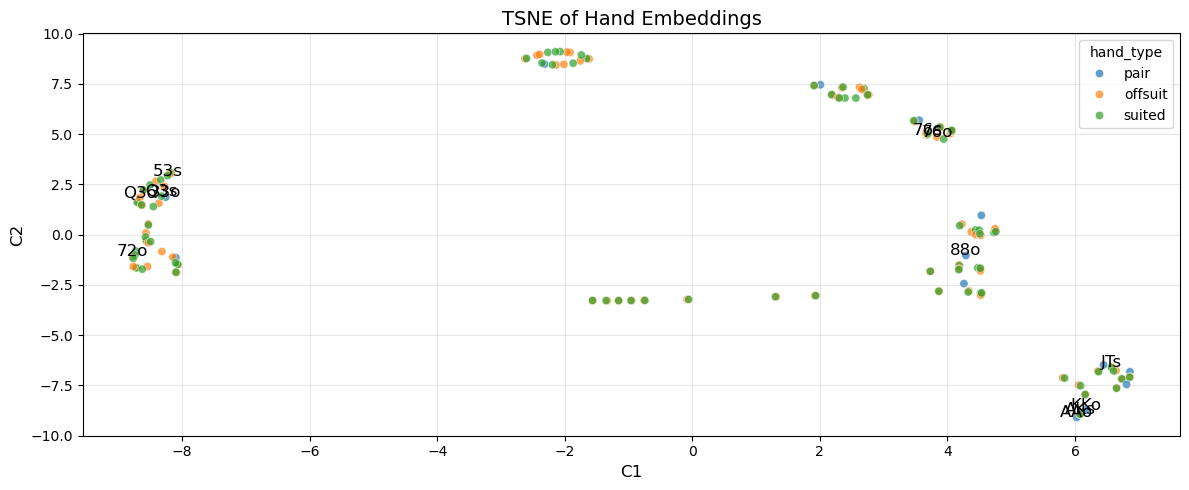

   hand         top_1         top_2         top_3       bottom_1  \
0   AAo  AKo (0.9558)  AKs (0.9523)  KKo (0.8518)  J4s (-0.2553)   
1   KKo  AKs (0.9629)  AKo (0.9624)  AQo (0.8803)  95o (-0.4534)   
2   72o  72s (0.9999)  82s (0.9996)  82o (0.9995)  T7s (-0.5008)   
3   76s  76o (0.9999)  86o (0.9998)  Q6o (0.9993)  T2s (-0.4625)   
4   76o  76s (0.9999)  86o (0.9996)  86s (0.9994)  T2s (-0.4665)   
5   Q3s  Q3o (0.9998)  83s (0.9985)  33o (0.9984)  T9o (-0.5387)   
6   Q3o  Q3s (0.9998)  93o (0.9992)  J3s (0.9986)  ATo (-0.5391)   
7   88o  98o (0.9948)  98s (0.9939)  Q8o (0.9910)  93s (-0.4848)   
8   JTs  JTo (1.0000)  QTo (0.9982)  QTs (0.9978)  94o (-0.5806)   
9   33o  Q3s (0.9984)  Q3o (0.9984)  93o (0.9981)  T9s (-0.5380)   
10  AKs  AKo (0.9997)  KKo (0.9629)  AAo (0.9523)  Q4s (-0.3724)   
11  53s  53o (0.9992)  43o (0.9987)  43s (0.9986)  AJo (-0.5628)   

         bottom_2       bottom_3  
0   T4o (-0.2554)  J4o (-0.2558)  
1   K5o (-0.4716)  K5s (-0.4738)  
2   J7o (-

In [359]:
similarity_df = analyze_embeddings(
    embeddings_agg, 
    hands_of_interest=['AAo','KKo','72o','76s','76o','Q3s',"Q3o",'88o','JTs','33o',"AKs","53s"],
    hand_feature_to_color='hand_type',
    figsize=(12,5)
    )

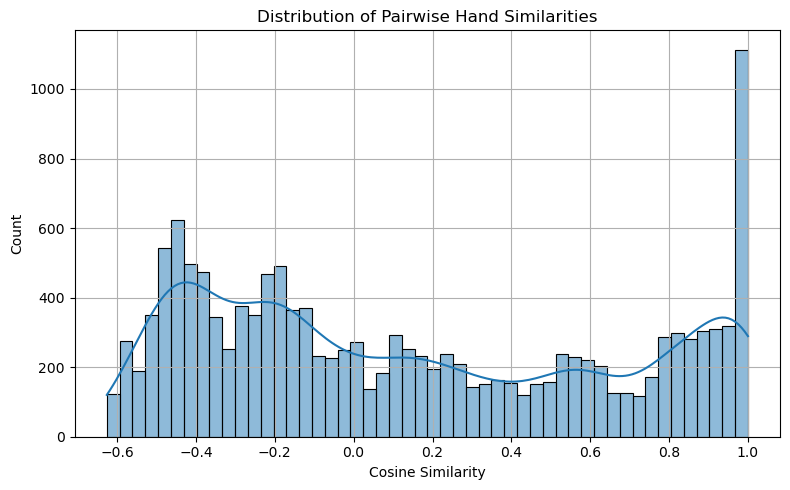

In [360]:
mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
pairwise_sims = similarity_df.where(mask)

all_similarities = pairwise_sims.stack().values

plt.figure(figsize=(8, 5))
sns.histplot(all_similarities, bins=50, kde=True)
plt.title("Distribution of Pairwise Hand Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [363]:
evaluate_hand_hand_equity(embeddings_agg, equity_matrix.to_numpy())

{'spear_corr': np.float64(0.32873725989813174), 'pval': np.float64(0.0)}

In [364]:
prob_data = pd.read_csv('data/processed/prob_data.csv')

In [365]:
prob_res = prob_embeddings(embeddings_agg, prob_data)

In [366]:
prob_res[prob_res.attribute == 'suited']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
0,suited,0,0.538462,0.538462,1.0,0.7,0.538462,NaN
1,suited,1,0.538462,0.000000,0.0,0.0,0.461538,NaN


In [367]:
prob_res[prob_res.attribute == 'connectedness']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
2,connectedness,0,0.39645,1.000000,0.076923,0.142857,0.076923,NaN
3,connectedness,1,0.39645,0.391304,0.692308,0.500000,0.153846,NaN
4,connectedness,2,0.39645,0.533333,0.333333,0.410256,0.142012,NaN
5,connectedness,3,0.39645,0.409091,0.409091,0.409091,0.130178,NaN
6,connectedness,4,0.39645,0.666667,0.400000,0.500000,0.118343,NaN
7,connectedness,5,0.39645,0.857143,0.333333,0.480000,0.106509,NaN
8,connectedness,6,0.39645,0.391304,0.562500,0.461538,0.094675,NaN
9,connectedness,7,0.39645,0.181818,0.200000,0.190476,0.059172,NaN
10,connectedness,8,0.39645,0.333333,0.750000,0.461538,0.047337,NaN
11,connectedness,9,0.39645,0.000000,0.000000,0.000000,0.035503,NaN


In [368]:
prob_res[prob_res.attribute == 'pair']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
14,pair,0,0.923077,0.923077,1.0,0.96,0.923077,NaN
15,pair,1,0.923077,0.000000,0.0,0.00,0.076923,NaN


In [369]:
prob_res[prob_res.attribute == 'broadway']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
60,broadway,0,0.822485,0.757576,0.78125,0.769231,0.378698,NaN
61,broadway,1,0.822485,0.820513,0.80000,0.810127,0.473373,NaN
62,broadway,2,0.822485,1.000000,1.00000,1.000000,0.147929,NaN


In [371]:
prob_res[prob_res.attribute.str.contains('play')]

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
10,BB_play10,NaN,NaN,NaN,NaN,NaN,NaN,0.212920
11,BB_play2,NaN,NaN,NaN,NaN,NaN,NaN,0.124082
12,BB_play3,NaN,NaN,NaN,NaN,NaN,NaN,0.160671
13,BB_play4,NaN,NaN,NaN,NaN,NaN,NaN,0.177304
14,BB_play5,NaN,NaN,NaN,NaN,NaN,NaN,0.197710
15,BB_play6,NaN,NaN,NaN,NaN,NaN,NaN,0.209606
16,BB_play7,NaN,NaN,NaN,NaN,NaN,NaN,0.213279
17,BB_play8,NaN,NaN,NaN,NaN,NaN,NaN,0.193799
18,BB_play9,NaN,NaN,NaN,NaN,NaN,NaN,0.205965
19,D_play10,NaN,NaN,NaN,NaN,NaN,NaN,0.212703
